<a href="https://colab.research.google.com/github/Mwangi-dan/sound_dataset_clustering/blob/main/Daniel_Ndungu_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [1]:
!pip install scikit-learn librosa

In [2]:
#Make allNecessary Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import librosa
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/Machine Learning BSE/Machine Learning Techniques II/unlabelled_sounds"

# Extracting features
features = []

In [5]:
# Extract Features (Mel Spectrogram)
for file in os.listdir(unlabelled_data_path):
    if file.endswith('.wav'):
        audio, sr = librosa.load(os.path.join(unlabelled_data_path, file))
        mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Summarize into a feature vector (e.g., mean across time)
        feature_vector = np.mean(mel_spec_db, axis=1)
        features.append(feature_vector)

features_array = np.array(features)

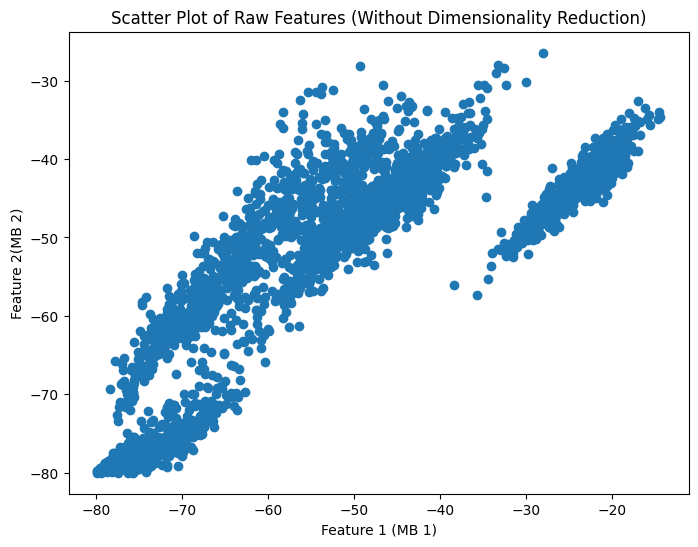

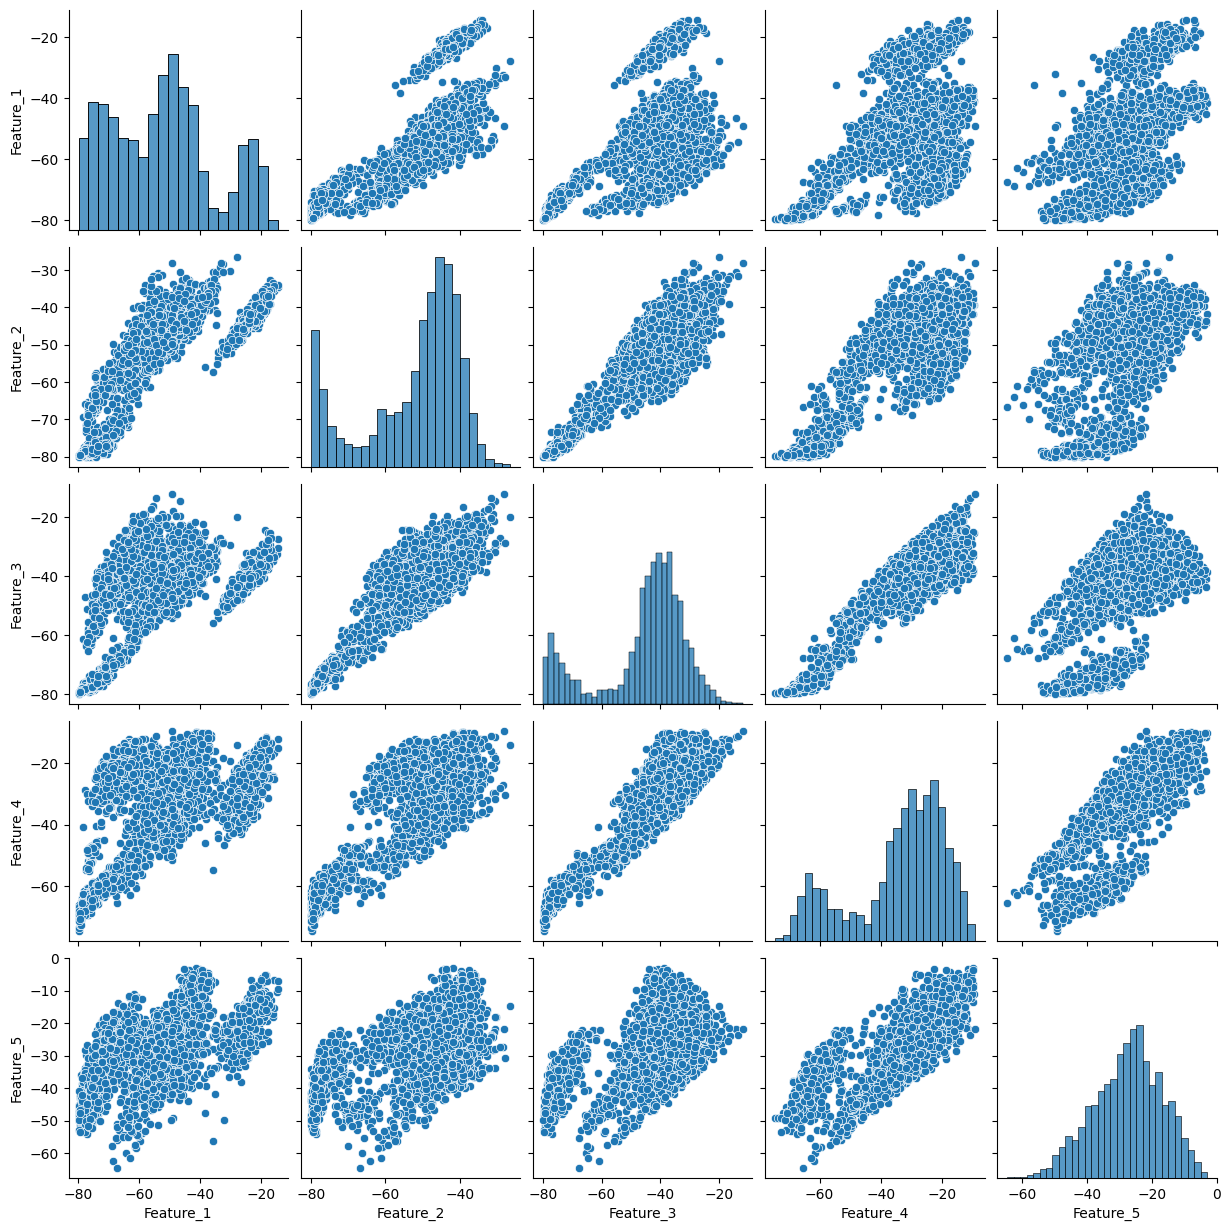

In [6]:

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1])
plt.xlabel("Feature 1 (MB 1)")
plt.ylabel("Feature 2(MB 2)")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature_{i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?
I had a challenge visualizing the raw 128-dimensional Mel Spectogram features directly as I was getting an error in plt.scatter() which requres 2D data. I had to pick two features.

The scatter plot looks dense causing one not to be able to discern patterns clearly and the pair plots have overlapping distributions with clusters that aren't very clear.

Because of this, I think dimensionality reduction is very important to make it easier to interpret clusters

Text(0.5, 0, 'PC3')

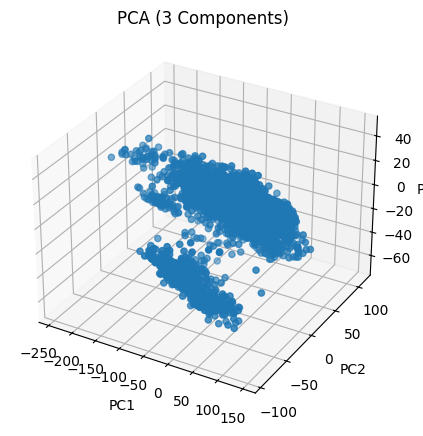

In [7]:

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization goes here
#PCA 3D PLOT
ax1 = plt.figure(figsize=(12, 5)).add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2])
ax1.set_title("PCA (3 Components)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")


Text(0.5, 0, 't-SNE 3')

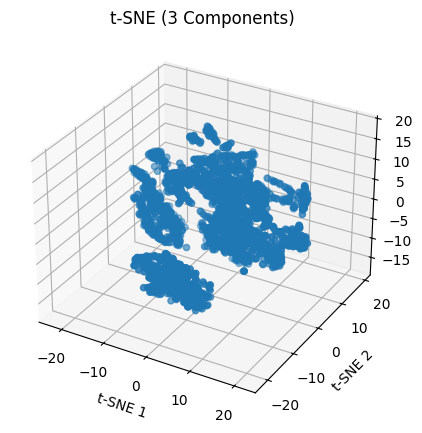

In [8]:
#t-SNE 3D Plot
ax2 = plt.figure(figsize=(12, 5)).add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2])
ax2.set_title("t-SNE (3 Components)")
ax2.set_xlabel("t-SNE 1")
ax2.set_ylabel("t-SNE 2")
ax2.set_zlabel("t-SNE 3")

### Which method (PCA or t-SNE) provides better separability of clusters and why?
t-SNE clearly shows better clusters than PCA.

Sound features have more complax, npon-linear patterns, t-SNEs lean towards local structures making it more effective for clustering.

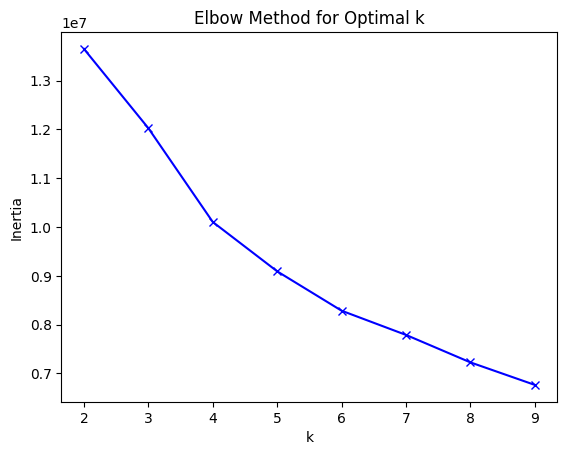

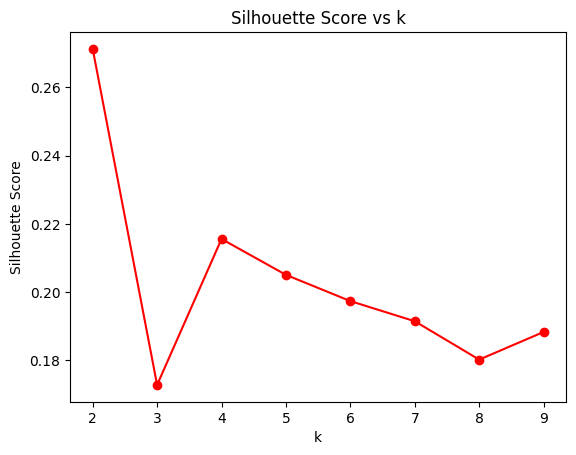

In [9]:

# Optimize number of clusters using Elbow Method
inertias = []
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    inertias.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(features_array, kmeans.labels_))


plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

plt.plot(k_range, sil_scores, 'ro-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.show()

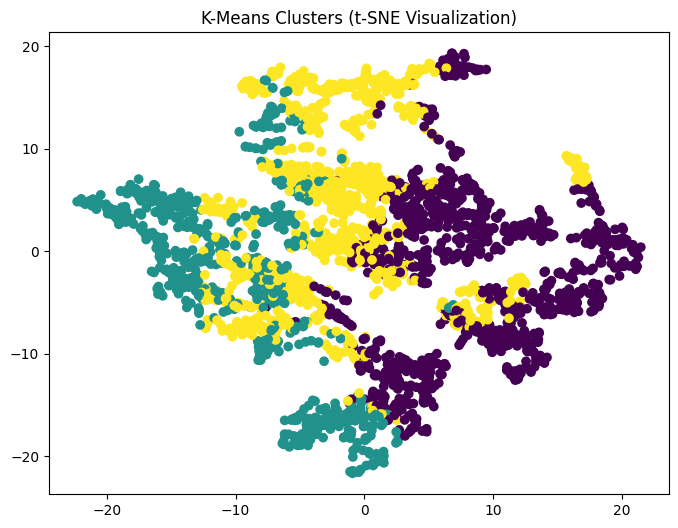

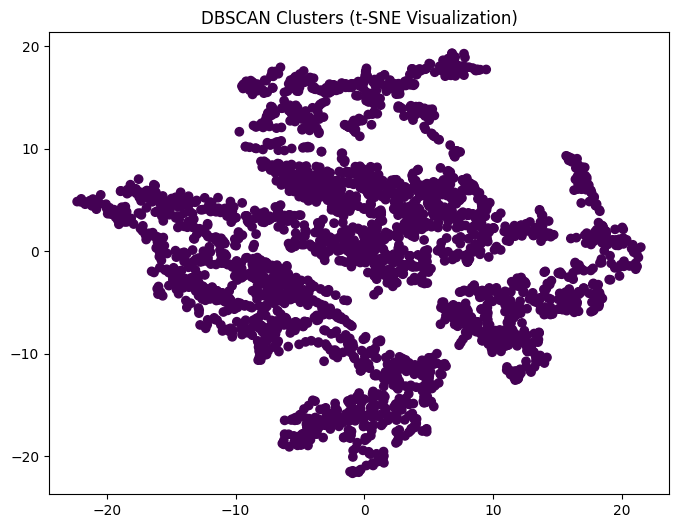

In [10]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(8,6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clusters (t-SNE Visualization)")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.figure(figsize=(8,6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clusters (t-SNE Visualization)")
plt.show()


In [11]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.1727, Davies-Bouldin Index: 1.7158
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
K-Means outperformed DBSCAN in my experiments, with a silhouette score of .1727.
DBSCAN failed to form meaningful clusters probably due to noise or just forming few clusters.

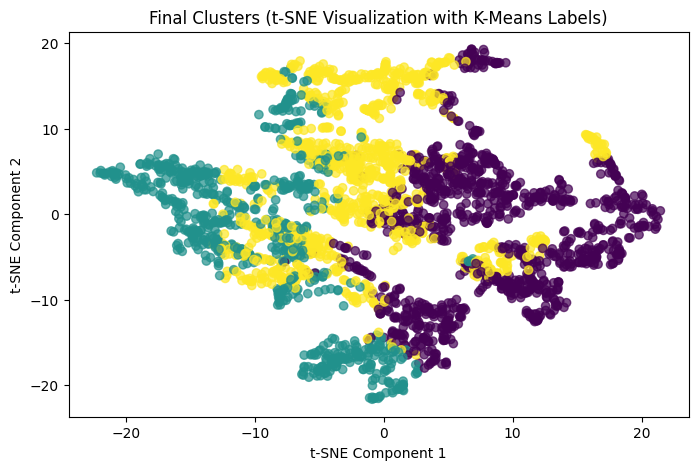

In [12]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
-- Dimensionality reduction improved clustering by revealing non-linear structures with the Mel Spectogram features. PCA showed less clustering probably because it only worked linearly hiding clusters visible from a higher dimension

- Justify why certain clustering methods worked better.
-- K-Means worked better it managed to form clear clusters unlike DBSCAN. Post t-SNE the structure was more simple which matched the clusters from K-Means while the ones from DBSCAN are more dense which is probably why they failed to adapt to the structure.

- Relate findings to real-world clustering challenges.
-- Audio recordings usually have noise, which make it necessary for non-linear forms of reduction to be utilised to handle such unlabeled, high dimension data effectively